In [1]:
import os
import zipfile
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random


Sample image channels: 3
Class to index mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35}


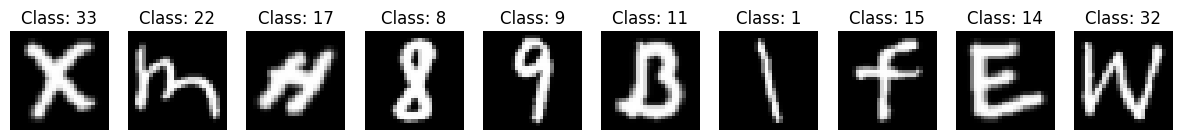

In [2]:
# Set a fixed random seed for reproducibility
torch.manual_seed(42)
import random
import numpy as np
random.seed(42)
np.random.seed(42)

# Path to your zip file and extraction destination
zip_path = 'cnn_dataset.zip'  # Update with the path to your zip file
extract_path = '/content/sample_data/cnn_dataset/cnn_dataset'  # Temporary folder for extraction

# Unzip the dataset if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Load a sample to check if the image is grayscale or RGB
temp_dataset = ImageFolder(root=extract_path, transform=transforms.ToTensor())
sample_img, sample_label = temp_dataset[0]
channels = sample_img.shape[0]
print(f"Sample image channels: {channels}")

# Define transformations based on the number of channels (for grayscale vs RGB)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,) * channels, (0.5,) * channels)  # Normalize dynamically based on channels
])

# Load the full dataset with the defined transform
full_dataset = ImageFolder(root=extract_path, transform=transform)

# Check class mappings in the dataset
print("Class to index mapping:", full_dataset.class_to_idx)

# Define split sizes for train, validation, and test sets
train_size = int(0.8 * len(full_dataset))   # 80% for training
val_size = int(0.1 * len(full_dataset))     # 10% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 10% for testing

# Split the dataset with a fixed seed
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize a few images from different classes in the training set
def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    sampled_images = []
    sampled_labels = []
    for img, label in DataLoader(dataset, batch_size=1, shuffle=True):
        # Collect images from different classes
        if label.item() not in sampled_labels:
            sampled_images.append((img.squeeze(0), label.item()))
            sampled_labels.append(label.item())
        if len(sampled_images) >= num_images:
            break
    for i, (img, label) in enumerate(sampled_images):
        img = img.squeeze().numpy() if channels == 1 else img.permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5)  # Unnormalize
        axes[i].imshow(img, cmap='gray' if channels == 1 else None)
        axes[i].set_title(f"Class: {label}")
        axes[i].axis('off')
    plt.show()

# Display sample images from different classes in the training set
show_images(train_dataset)


In [3]:
!pip install torchinfo

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

# Define the CNN model with dynamic flattening
class CharacterCNN(nn.Module):
    def __init__(self):
        super(CharacterCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Fully connected layers
        # Placeholder for the first FC layer, we'll calculate the input size dynamically
        self.fc1 = nn.Linear(128 * 7 * 7, 128)  # Assuming image is 7x7 after conv layers and pooling
        self.fc2 = nn.Linear(128, 36)  # 36 output classes

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))

        # Flatten dynamically
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        # Fully connected layers with ReLU and Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer

        return F.log_softmax(x, dim=1)  # Log softmax for probability distribution

# Initialize the model
model = CharacterCNN()

# Print model summary to verify architecture
summary(model, input_size=(64, 3, 28, 28))  # Batch size of 64


Layer (type:depth-idx)                   Output Shape              Param #
CharacterCNN                             [64, 36]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          896
├─MaxPool2d: 1-2                         [64, 32, 14, 14]          --
├─Conv2d: 1-3                            [64, 64, 14, 14]          18,496
├─MaxPool2d: 1-4                         [64, 64, 7, 7]            --
├─Conv2d: 1-5                            [64, 128, 7, 7]           73,856
├─Linear: 1-6                            [64, 128]                 802,944
├─Dropout: 1-7                           [64, 128]                 --
├─Linear: 1-8                            [64, 36]                  4,644
Total params: 900,836
Trainable params: 900,836
Non-trainable params: 0
Total mult-adds (M): 560.27
Input size (MB): 0.60
Forward/backward pass size (MB): 22.56
Params size (MB): 3.60
Estimated Total Size (MB): 26.77

In [5]:
import torch
import torch.optim as optim
import time
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score

# Augmentation and normalization transformations
augment_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * channels, (0.5,) * channels)
])

# Reload the dataset with the updated augmentation transform
full_dataset = ImageFolder(root=extract_path, transform=augment_transform)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Redefine DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model with Batch Normalization
class EnhancedCharacterCNN(nn.Module):
    def __init__(self):
        super(EnhancedCharacterCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 36)  # 36 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Initialize the model, loss function, optimizer, and learning rate scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedCharacterCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Halve the learning rate every 5 epochs

# Training loop with model saving
best_val_loss = float('inf')
epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy for this batch
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Calculate and store training accuracy for this epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / len(val_loader.dataset)
    val_accuracies.append(val_accuracy)

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_weights.pth')

    scheduler.step()  # Adjust the learning rate based on scheduler

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")

print("Training complete.")


Epoch 1/10, Train Loss: 1.2953, Train Accuracy: 0.5790, Val Loss: 0.5923, Val Accuracy: 0.7963, Time: 302.10s
Epoch 2/10, Train Loss: 0.8597, Train Accuracy: 0.7077, Val Loss: 0.5067, Val Accuracy: 0.8242, Time: 312.12s
Epoch 3/10, Train Loss: 0.7485, Train Accuracy: 0.7436, Val Loss: 0.4462, Val Accuracy: 0.8446, Time: 307.89s
Epoch 4/10, Train Loss: 0.6851, Train Accuracy: 0.7650, Val Loss: 0.4348, Val Accuracy: 0.8396, Time: 310.21s
Epoch 5/10, Train Loss: 0.6360, Train Accuracy: 0.7820, Val Loss: 0.4196, Val Accuracy: 0.8505, Time: 308.00s
Epoch 6/10, Train Loss: 0.5518, Train Accuracy: 0.8121, Val Loss: 0.3674, Val Accuracy: 0.8697, Time: 307.92s
Epoch 7/10, Train Loss: 0.5302, Train Accuracy: 0.8203, Val Loss: 0.3583, Val Accuracy: 0.8739, Time: 305.36s
Epoch 8/10, Train Loss: 0.5220, Train Accuracy: 0.8215, Val Loss: 0.3577, Val Accuracy: 0.8768, Time: 307.47s
Epoch 9/10, Train Loss: 0.5079, Train Accuracy: 0.8245, Val Loss: 0.3601, Val Accuracy: 0.8755, Time: 307.95s
Epoch 10/1

In [6]:
# Load the best model weights for evaluation
model.load_state_dict(torch.load('best_model_weights.pth'))


<ipython-input-6-ae0197806276>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_weights.pth'))


<All keys matched successfully>

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

# Load the best model weights
model.load_state_dict(torch.load('best_model_weights.pth', weights_only=True))  # Set weights_only=True to avoid warning

# Set the model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Track test metrics
all_preds = []
all_labels = []
test_loss = 0.0  # Initialize test loss

# Start timer for evaluation
start_time = time.time()

# Perform evaluation on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)  # Accumulate test loss

        # Get predictions
        _, preds = torch.max(outputs, 1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# End timer for evaluation
end_time = time.time()
evaluation_time = end_time - start_time

# Calculate final test metrics
test_accuracy = accuracy_score(all_labels, all_preds)
test_loss = test_loss / len(test_loader.dataset)  # Average test loss

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

# Print metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print(f"Time to evaluate the test set: {evaluation_time:.2f} seconds")


Test Accuracy: 0.8816
Test Loss: 0.3282
Precision: 0.8921, Recall: 0.8816, F1 Score: 0.8795
Time to evaluate the test set: 16.87 seconds


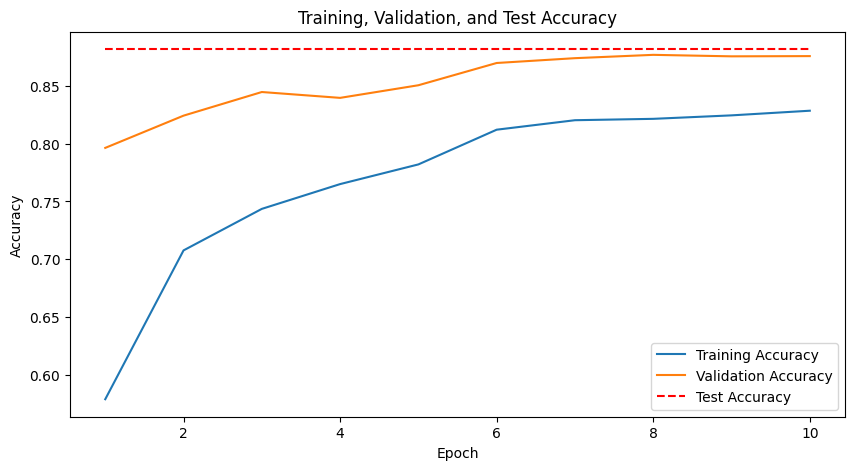

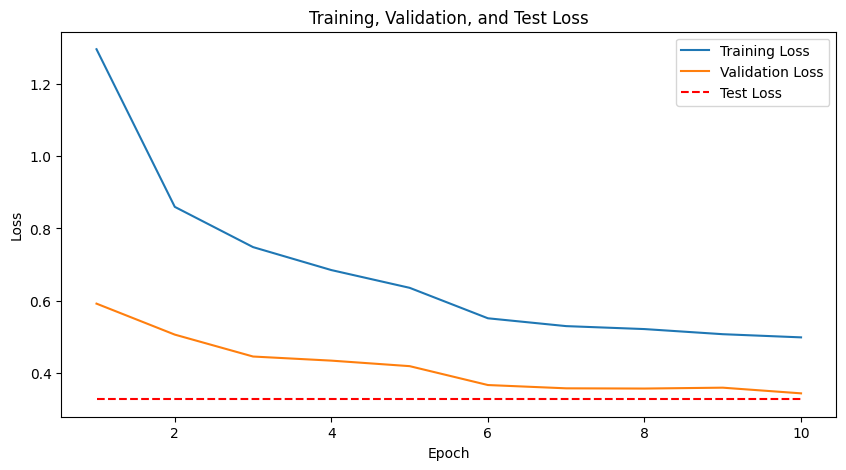

In [10]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, len(train_accuracies) + 1)

# 1. Plot Training, Validation, and Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, [test_accuracy] * len(epochs), label='Test Accuracy', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

# 2. Plot Training, Validation, and Test Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, [test_loss] * len(epochs), label='Test Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()


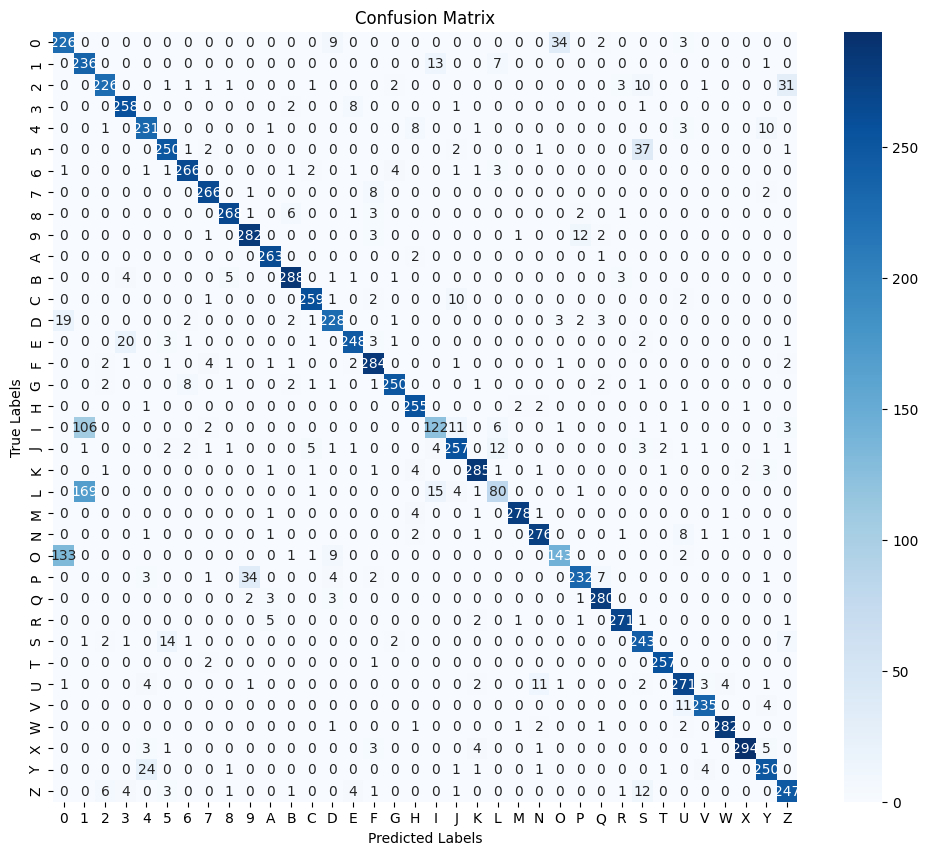

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


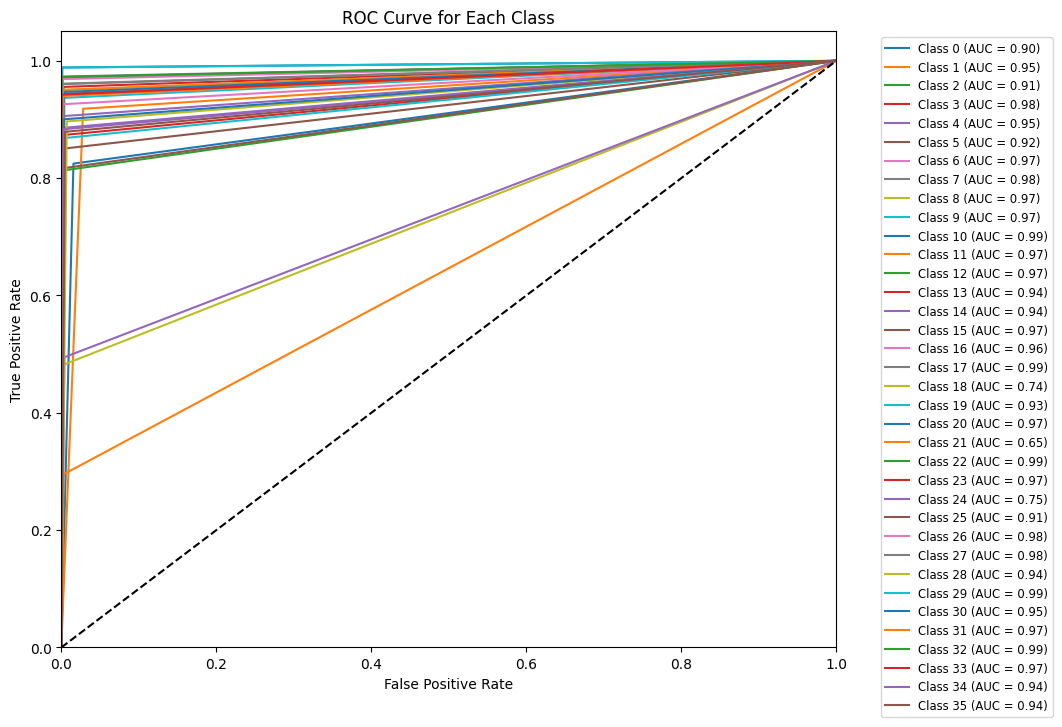

In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve for each class (One-vs-Rest approach)
all_labels_bin = label_binarize(all_labels, classes=list(range(36)))
all_preds_bin = label_binarize(all_preds, classes=list(range(36)))

plt.figure(figsize=(10, 8))
for i in range(36):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.show()


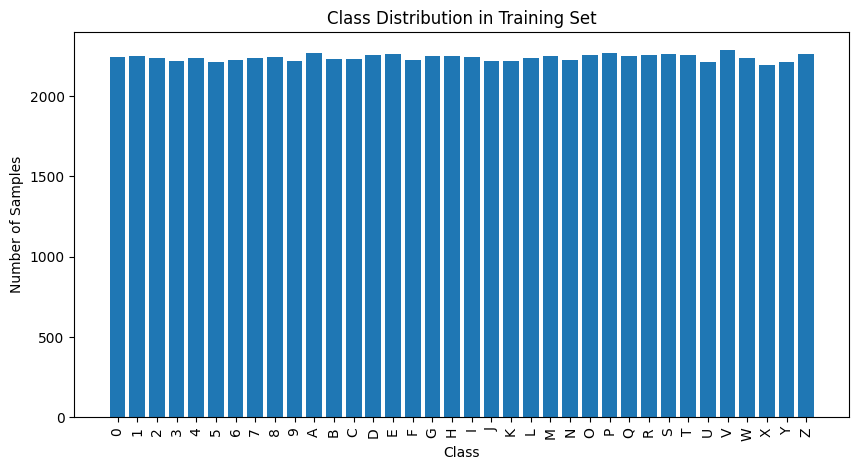

In [17]:
# Class distribution histogram using full_dataset for class names
class_counts = [0] * len(full_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1

plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), class_counts, tick_label=full_dataset.classes)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=90)
plt.show()


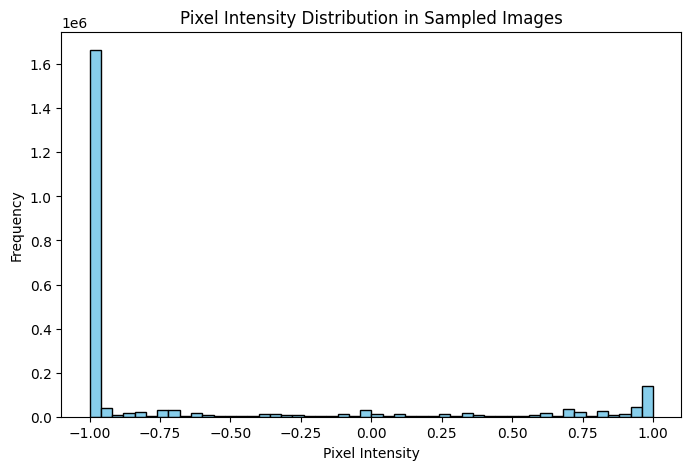

In [18]:
import numpy as np

# Collect pixel values from a sample of images to avoid using the entire dataset
num_samples = 1000  # Adjust this as needed
pixel_values = []

for i in range(num_samples):
    img, _ = train_dataset[i]
    img = img.numpy().flatten()  # Flatten the image to get all pixel values
    pixel_values.extend(img)

# Plot histogram of pixel values
plt.figure(figsize=(8, 5))
plt.hist(pixel_values, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution in Sampled Images')
plt.show()
